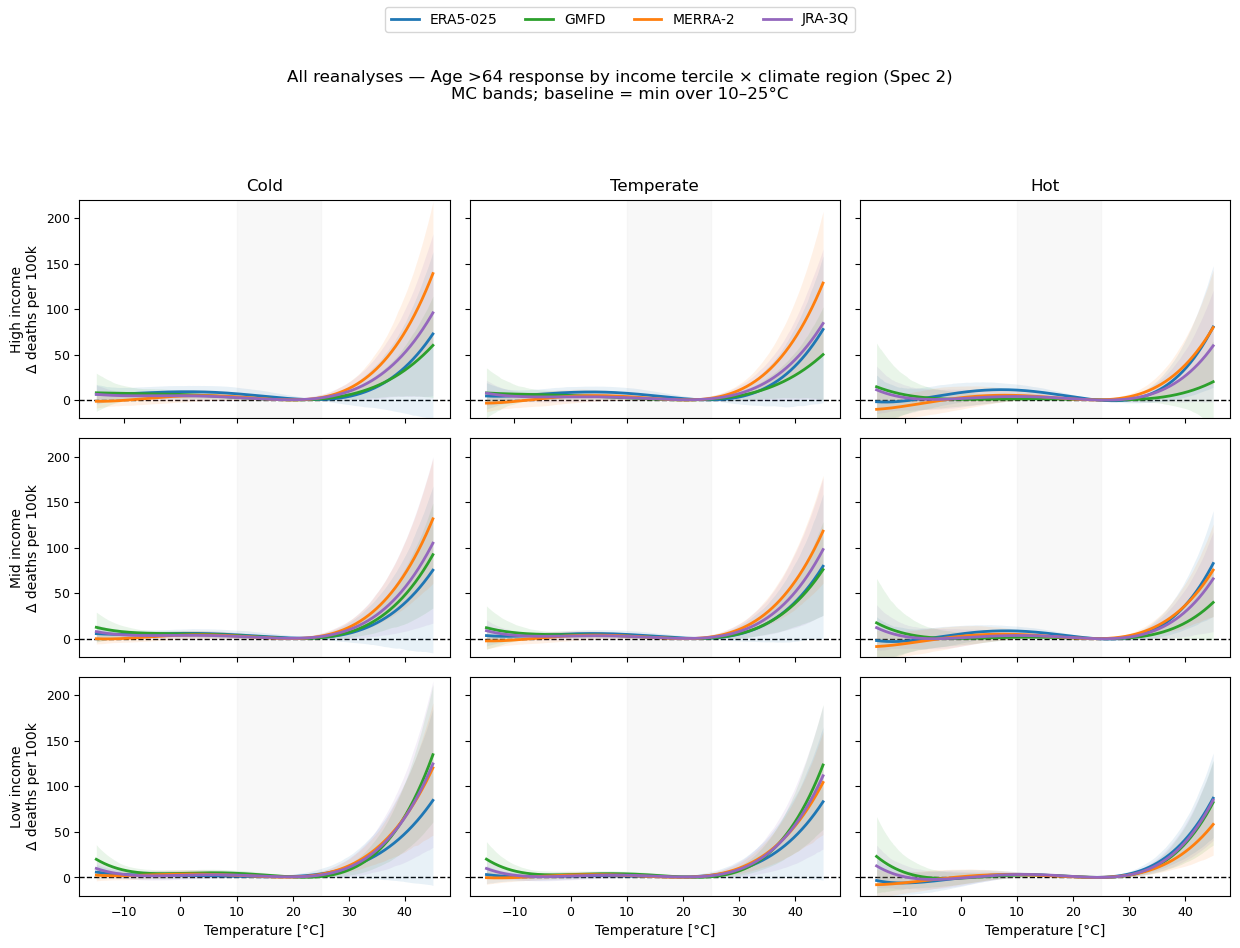


[Sanity] Population shares by tercile (%):
Income: {'high': 22.7, 'low': 55.9, 'mid': 21.5}
Temp  : {'cold': 26.2, 'hot': 49.6, 'temperate': 24.2}

[Sanity] Mean LR (°C) by cell:
temp_region  cold   hot  temperate
income_terc                       
high          8.1  15.1       10.6
low           9.2  20.0       11.4
mid           7.9  15.7       11.0

[Sanity] Mean log-income by cell:
temp_region   cold    hot  temperate
income_terc                         
high         10.52  10.32      10.47
low           9.36   9.36       9.40
mid          10.04  10.00      10.07


/tmp/8415216.1.debian.q/ipykernel_12673/331076850.py:342: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [24]:
# fig1_overlay.py
# Replicates Figure 1: 3×3 (income terciles × climate regions) with 4 products overlaid, Age 65+
# Uses GMFD-2010 bins for (income_terc, temp_region), and column-shared LR per product (toggle-able)

from __future__ import annotations
import re
from pathlib import Path
from functools import lru_cache
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- Paths & constants -----------------------------
BASE = Path("/user/ab5405/summeraliaclimate")
BINS_DIR   = BASE / "code/regressions/bins"
PANELS_DIR = BASE / "code/regressions/prep_panels"
CSVV_DIR   = BASE / "code/regressions/output/age_spec_interacted_csvv"

PRODUCTS = ["ERA5_025", "GMFD", "MERRA2", "JRA_3Q"]
YEAR_REF = 2010
AGE_LABEL = "65+"

# plotting / MC
TMIN, TMAX = -15.0, 45.0
SLICE_MIN, SLICE_MAX = 10.0, 25.0
AGE_IDX = 2  # 65+ block
N_DRAWS = 800
RNG = np.random.default_rng(123)

# Figure style
PROD_STYLE = {
    "ERA5_025": dict(label="ERA5-025", color="#1f77b4"),
    "GMFD":     dict(label="GMFD",     color="#2ca02c"),
    "MERRA2":   dict(label="MERRA-2",  color="#ff7f0e"),
    "JRA_3Q":   dict(label="JRA-3Q",   color="#9467bd"),
}

INCS = ["high", "mid", "low"]
REGS = ["cold", "temperate", "hot"]

# Toggle: use column-shared LR (same LR within a climate column for a given product)
USE_COLUMN_SHARED_LR = True

# ----------------------------- Utilities -----------------------------
def wavg(series: pd.Series, weights: pd.Series) -> float:
    s = series.to_numpy(float)
    w = weights.to_numpy(float)
    m = np.isfinite(s) & np.isfinite(w) & (w > 0)
    return float(np.average(s[m], weights=w[m])) if m.any() else np.nan

def weighted_terciles_from_values(x: pd.Series, w: pd.Series) -> pd.Series:
    # Global pop-weighted terciles; returns labels {low, mid, high}
    order = np.argsort(x.values)
    xs, ws = x.values[order], w.values[order]
    cdf = np.cumsum(ws) / ws.sum()
    t1 = xs[np.searchsorted(cdf, 1/3)]
    t2 = xs[np.searchsorted(cdf, 2/3)]
    return pd.cut(x, [-np.inf, t1, t2, np.inf], labels=["low","mid","high"], include_lowest=True)

def _lr_colname(cols, product: str) -> str:
    for cand in (f"lr_tavg_{product}_adm1_avg", f"lr_tavg_{product.replace('_','-')}_adm1_avg"):
        if cand in cols: return cand
    for c in cols:
        if re.fullmatch(r"lr_tavg_[^,]+_adm1_avg", c): return c
    raise KeyError(f"No lr_tavg_*_adm1_avg column found for {product}")

def _read_gamma_and_vcv(csvv_path: Path):
    txt = Path(csvv_path).read_text()
    _FLOAT = r"[-+]?(?:\d+\.?\d*|\.\d+)(?:[Ee][-+]?\d+)?"
    g_block = re.search(r"\bgamma\s*(.*?)\bgammavcv\b", txt, flags=re.S|re.I)
    v_block = re.search(r"\bgammavcv\b(.*)\Z",           txt, flags=re.S|re.I)
    if not g_block or not v_block:
        raise ValueError(f"Could not find gamma / gammavcv in {csvv_path}")
    g = [float(x) for x in re.findall(_FLOAT, g_block.group(1))]
    v = [float(x) for x in re.findall(_FLOAT, v_block.group(1))]
    gamma    = np.array(g[:36], float).reshape(3,4,3)     # [age, poly, cov(1,LR,logy)]
    gammavcv = np.array(v[:36*36], float).reshape(36,36)
    return gamma, gammavcv

def _mc_bands_for_cell(T, slice_min, slice_max, lr_tavg, loggdppc, gamma_mean, gamma_vcv,
                       age_index=AGE_IDX, n_draws=N_DRAWS, rng=RNG):
    g_flat = gamma_mean.reshape(-1)
    draws = rng.multivariate_normal(g_flat, gamma_vcv, size=n_draws).reshape(n_draws, 3, 4, 3)
    # Effective coefficients for this (lr, logy)
    b1 = draws[:, age_index, 0, 0] + draws[:, age_index, 0, 1]*lr_tavg + draws[:, age_index, 0, 2]*loggdppc
    b2 = draws[:, age_index, 1, 0] + draws[:, age_index, 1, 1]*lr_tavg + draws[:, age_index, 1, 2]*loggdppc
    b3 = draws[:, age_index, 2, 0] + draws[:, age_index, 2, 1]*lr_tavg + draws[:, age_index, 2, 2]*loggdppc
    b4 = draws[:, age_index, 3, 0] + draws[:, age_index, 3, 1]*lr_tavg + draws[:, age_index, 3, 2]*loggdppc
    eff = np.column_stack([b1, b2, b3, b4])                            # (n_draws, 4)
    Tpow = np.vstack([T, T**2, T**3, T**4])                            # (4, len(T))
    y_raw = eff @ Tpow                                                 # (n_draws, len(T))

    # Normalize at min over [slice_min, slice_max]
    win = (T >= slice_min) & (T <= slice_max)
    base = np.nanmin(y_raw[:, win], axis=1)
    y = y_raw - base[:, None]

    y_mean = np.nanmean(y, axis=0)
    y_lo, y_hi = np.nanpercentile(y, [5, 95], axis=0)
    return y_mean, y_lo, y_hi

# ----------------------------- Bins (GMFD-2010) -----------------------------
def load_bins_labels(bins_dir: Path) -> pd.DataFrame:
    # Expect gmfd_bins_labels.{csv|parquet} with columns: adm2_id, income_terc, temp_region (strings)
    csv_path = bins_dir / "gmfd_bins_labels.csv"
    pq_path  = bins_dir / "gmfd_bins_labels.parquet"
    usecols  = ["adm2_id","income_terc","temp_region"]
    if csv_path.exists():
        out = pd.read_csv(csv_path, usecols=usecols, dtype={"adm2_id":"string"})
    elif pq_path.exists():
        out = pd.read_parquet(pq_path, columns=usecols)
    else:
        raise FileNotFoundError("gmfd_bins_labels.{csv|parquet} not found")
    out["adm2_id"] = out["adm2_id"].astype(str)
    out["income_terc"] = out["income_terc"].astype(str)
    out["temp_region"] = out["temp_region"].astype(str)
    return out

def build_cell_index(labels: pd.DataFrame) -> dict[tuple[str,str], set[str]]:
    d = labels[["adm2_id","income_terc","temp_region"]].copy()
    d["cell"] = list(zip(d["income_terc"], d["temp_region"]))
    return {cell: set(g["adm2_id"]) for cell, g in d.groupby("cell")}

# ----------------------------- Cell means per product -----------------------------

def resolve_lr_col_from_file(dta_path: str | Path, product: str) -> str:
    chunk = next(iter(pd.read_stata(str(dta_path), iterator=True, chunksize=1000)))
    exact = f"lr_tavg_{product}_adm1_avg"
    if exact in chunk.columns: return exact
    cands = [c for c in chunk.columns if c.startswith("lr_tavg_") and c.endswith("_adm1_avg")]
    if len(cands) == 1: return cands[0]
    raise KeyError(f"LR col not found in {dta_path}. Tried '{exact}', candidates: {sorted(cands)}")


def cell_means_streaming(
    dta_path,
    product,
    ids_adm2,
    *,
    year=2010,
    weight_base="total",   # "total" or "age"
    age_label="65+",
    loginc_col="loggdppc_adm1_avg",
    lr_col=None,
    chunksize=200_000,
):
    """
    Returns (lr_mean, loginc_mean) as *weighted averages across the selected ADM2s*.
    We first collapse each chunk to unique adm2_id to avoid double-counting.
    weight_base:
      - "total": sum weights across all ages in 'year' (recommended for bins/column LR)
      - "age"  : use only age_label's population (for age-specific displays)
    """
    import numpy as np, pandas as pd

    def _resolve_lr_col(path, product):
        exact = f"lr_tavg_{product}_adm1_avg"
        # cheap probe
        cols0 = next(iter(pd.read_stata(str(path), iterator=True, chunksize=1))).columns
        if exact in cols0: return exact
        cands = [c for c in cols0 if c.startswith("lr_tavg_") and c.endswith("_adm1_avg")]
        if len(cands)==1: return cands[0]
        raise KeyError(f"LR col not found. Tried {exact}; candidates={cands}")

    lr_col = lr_col or _resolve_lr_col(dta_path, product)

    need = ["adm2_id","year", "population", loginc_col, lr_col]
    if weight_base == "age":
        need += ["agegroup"]

    rdr = pd.read_stata(str(dta_path), iterator=True, chunksize=chunksize, columns=need)

    w_sum = 0.0
    wlr_sum = 0.0
    wlog_sum = 0.0

    ids_adm2 = set(map(str, ids_adm2))

    for ch in rdr:
        ch = ch.copy()
        ch["adm2_id"] = ch["adm2_id"].astype(str)

        # Filter to target year and ADM2 set
        ch = ch[(ch["year"] == year) & (ch["adm2_id"].isin(ids_adm2))]
        if ch.empty:
            continue

        # Choose weight base
        if weight_base == "age":
            ch = ch[ch["agegroup"] == age_label]
            if ch.empty:
                continue
            # collapse within adm2_id: LR/log are constant within ADM2; take first; sum weights
            sub = (ch.groupby("adm2_id", as_index=False)
                     .agg(pop=("population","sum"),
                          lr=(lr_col,"first"),
                          logy=(loginc_col,"first")))
        else:  # "total"
            # collapse *across all ages*: sum population; take first of LR/log per adm2
            sub = (ch.groupby("adm2_id", as_index=False)
                     .agg(pop=("population","sum"),
                          lr=(lr_col,"first"),
                          logy=(loginc_col,"first")))

        sub = sub.dropna(subset=["pop","lr","logy"])
        if sub.empty:
            continue

        w = sub["pop"].to_numpy("float64")
        lr = sub["lr"].to_numpy("float64")
        lg = sub["logy"].to_numpy("float64")

        m = np.isfinite(w) & np.isfinite(lr) & np.isfinite(lg) & (w > 0)
        if not m.any():
            continue

        w = w[m]; lr = lr[m]; lg = lg[m]
        w_sum   += float(w.sum())
        wlr_sum += float((w * lr).sum())
        wlog_sum+= float((w * lg).sum())

    if w_sum == 0.0:
        raise ValueError("No rows matched after filtering/collapse.")

    return wlr_sum / w_sum, wlog_sum / w_sum

def build_CELL_MEANS_and_REGION_LR(products: list[str], dta_base: Path,
                                   idx: dict[tuple[str,str], set[str]]) -> tuple[dict, dict]:
    dta_paths = {p: dta_base / f"global_mortality_panel_public_{p}.dta" for p in products}
    CELL_MEANS = {}
    REGION_LR  = {}
    for prod in products:
        rows = []
        # Column-shared LR: precompute once per climate region (union over income terciles)
        for reg in REGS:
            ids_union = set().union(*(idx.get((inc, reg), set()) for inc in INCS))
            if ids_union:
                lr_mean_reg, _ = cell_means_streaming(dta_paths[prod], prod, ids_union)
                REGION_LR[(prod, reg)] = float(lr_mean_reg)
        # Per-cell means (we will always use per-cell income)
        for inc in INCS:
            for reg in REGS:
                ids = idx.get((inc, reg), set())
                if not ids: continue
                lr_mean, log_mean = cell_means_streaming(dta_paths[prod], prod, ids)
                rows.append([inc, reg, float(lr_mean), float(log_mean)])
        CELL_MEANS[prod] = pd.DataFrame(rows, columns=["income_terc","temp_region","lr_mean","loginc"])
    return CELL_MEANS, REGION_LR

# ----------------------------- Plot (Figure 1 overlay) -----------------------------
def plot_overlay_3x3(CELL_MEANS: dict[str,pd.DataFrame],
                     REGION_LR: dict[tuple[str,str],float],
                     gamma_cache: dict[str, tuple[np.ndarray,np.ndarray]],
                     *,
                     use_column_shared_lr: bool = True):
    T = np.linspace(TMIN, TMAX, 800)
    fig, axes = plt.subplots(3, 3, figsize=(12.5, 9.5), sharex=True, sharey=True)
    legend_handles = []

    for i, inc in enumerate(INCS):
        for j, reg in enumerate(REGS):
            ax = axes[i, j]
            ax.axvspan(SLICE_MIN, SLICE_MAX, color="0.9", alpha=0.25, zorder=0)
            ax.axhline(0, color="k", ls="--", lw=1, zorder=1)

            for prod in PRODUCTS:
                df = CELL_MEANS[prod]
                r = df[(df.income_terc==inc) & (df.temp_region==reg)]
                if r.empty:
                    continue
                row = r.iloc[0]
                lr_for_panel = REGION_LR[(prod, reg)] if use_column_shared_lr else float(row.lr_mean)
                loginc_for_panel = float(row.loginc)

                gm, gv = gamma_cache[prod]
                y_mean, y_lo, y_hi = _mc_bands_for_cell(
                    T, SLICE_MIN, SLICE_MAX,
                    lr_tavg=lr_for_panel,
                    loggdppc=loginc_for_panel,
                    gamma_mean=gm, gamma_vcv=gv,
                    age_index=AGE_IDX, n_draws=N_DRAWS, rng=RNG
                )
                style = PROD_STYLE[prod]
                (ln,) = ax.plot(T, y_mean, lw=2.0, **style, zorder=3)
                ax.fill_between(T, y_lo, y_hi, alpha=0.10, color=style["color"], linewidth=0, zorder=2)
                if i==0 and j==0:
                    legend_handles.append(ln)

            if i == 0: ax.set_title(reg.capitalize())
            if j == 0: ax.set_ylabel(f"{inc.capitalize()} income\nΔ deaths per 100k")

    for ax in axes[-1, :]:
        ax.set_xlabel("Temperature [°C]")
    for ax in axes.flat:
        ax.set_ylim(-20, 220)
        ax.set_yticks([0,50,100,150,200])
        ax.tick_params(labelsize=9)

    fig.subplots_adjust(top=0.84)
    fig.legend(handles=legend_handles,
               labels=[PROD_STYLE[p]["label"] for p in PRODUCTS],
               loc="upper center", ncol=len(PRODUCTS), frameon=True, fontsize=10)
    fig.suptitle(
        "All reanalyses — Age >64 response by income tercile × climate region (Spec 2)\n"
        "MC bands; baseline = min over 10–25°C",
        y=0.93
    )
    plt.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()

# ----------------------------- Sanity checks -----------------------------
def sanity_population_shares(bins: pd.DataFrame, panel2010: pd.DataFrame):
    # Build per-ADM2 2010 aggregates (pop2010, lr, logy) to mirror bin construction
    use = ["adm2_id","year","agegroup","population","lr_tavg_GMFD_adm1_avg","loggdppc_adm1_avg"]
    df2010 = panel2010[use].copy()
    df2010 = df2010[df2010["year"]==YEAR_REF].copy()
    df2010["adm2_id"] = df2010["adm2_id"].astype(str)
    adm2_agg = (df2010
        .sort_values(["adm2_id","agegroup"])
        .groupby("adm2_id", as_index=False)
        .agg(pop2010=("population","sum"),
             lr=("lr_tavg_GMFD_adm1_avg","first"),
             logy=("loggdppc_adm1_avg","first"))
        .dropna(subset=["pop2010","lr","logy"]))

    merged = bins.merge(adm2_agg, on="adm2_id", how="left")

    inc_share = (merged.groupby("income_terc")["pop2010"].sum() / merged["pop2010"].sum() * 100).round(1)
    tmp_share = (merged.groupby("temp_region")["pop2010"].sum() / merged["pop2010"].sum() * 100).round(1)
    print("\n[Sanity] Population shares by tercile (%):")
    print("Income:", inc_share.to_dict())
    print("Temp  :", tmp_share.to_dict())

def sanity_monotonic_means(bins: pd.DataFrame, panel2010: pd.DataFrame):
    use = ["adm2_id","year","agegroup","population","lr_tavg_GMFD_adm1_avg","loggdppc_adm1_avg"]
    df2010 = panel2010[use].copy()
    df2010 = df2010[df2010["year"]==YEAR_REF].copy()
    df2010["adm2_id"] = df2010["adm2_id"].astype(str)
    # attach bins
    merged = df2010.merge(bins, on="adm2_id", how="left")
    tab = (merged.groupby(["income_terc","temp_region"])
           .apply(lambda g: pd.Series({
               "lr_mean"  : wavg(g["lr_tavg_GMFD_adm1_avg"], g["population"]),
               "logy_mean": wavg(g["loggdppc_adm1_avg"],     g["population"])
           }))
           .reset_index())

    print("\n[Sanity] Mean LR (°C) by cell:")
    print(tab.pivot(index="income_terc", columns="temp_region", values="lr_mean").round(1))
    print("\n[Sanity] Mean log-income by cell:")
    print(tab.pivot(index="income_terc", columns="temp_region", values="logy_mean").round(2))

    # Monotonic checks (tolerant)
    for inc in INCS:
        row = tab[tab["income_terc"]==inc].set_index("temp_region").loc[REGS, "lr_mean"].to_numpy()
        assert np.all(np.diff(row) >= -1e-6), f"Non-monotone LR across regions for income={inc}"

    for reg in REGS:
        col = tab[tab["temp_region"]==reg].set_index("income_terc").loc[["low","mid","high"], "logy_mean"].to_numpy()
        assert np.all(np.diff(col) >= -1e-6), f"Non-monotone log-income across income terciles for region={reg}"

# ----------------------------- Main -----------------------------
def main():
    # 1) Load GMFD bins (2010)
    bins = load_bins_labels(BINS_DIR)
    idx = build_cell_index(bins)

    # 2) Build per-product cell means & column-shared LR
    CELL_MEANS, REGION_LR = build_CELL_MEANS_and_REGION_LR(PRODUCTS, PANELS_DIR, idx)

    # 3) Load CSVVs (gamma + VCV) per product
    gamma_cache = {}
    for prod in PRODUCTS:
        csvv_path = CSVV_DIR / f"agespec_interaction_response_spec2_{prod}.csvv"
        gm, gv = _read_gamma_and_vcv(csvv_path)
        gamma_cache[prod] = (gm, gv)

    # 4) Plot overlay (Figure 1)
    plot_overlay_3x3(CELL_MEANS, REGION_LR, gamma_cache,
                     use_column_shared_lr=USE_COLUMN_SHARED_LR)

    # 5) Sanity checks (bins coherence)
    #    Use GMFD panel for 2010 aggregates to mirror your bin construction
    gmfd_panel_path = PANELS_DIR / "global_mortality_panel_public_GMFD.dta"
    gmfd2010 = pd.read_stata(str(gmfd_panel_path), iterator=False, convert_categoricals=False)
    sanity_population_shares(bins, gmfd2010)
    sanity_monotonic_means(bins, gmfd2010)

if __name__ == "__main__":
    main()


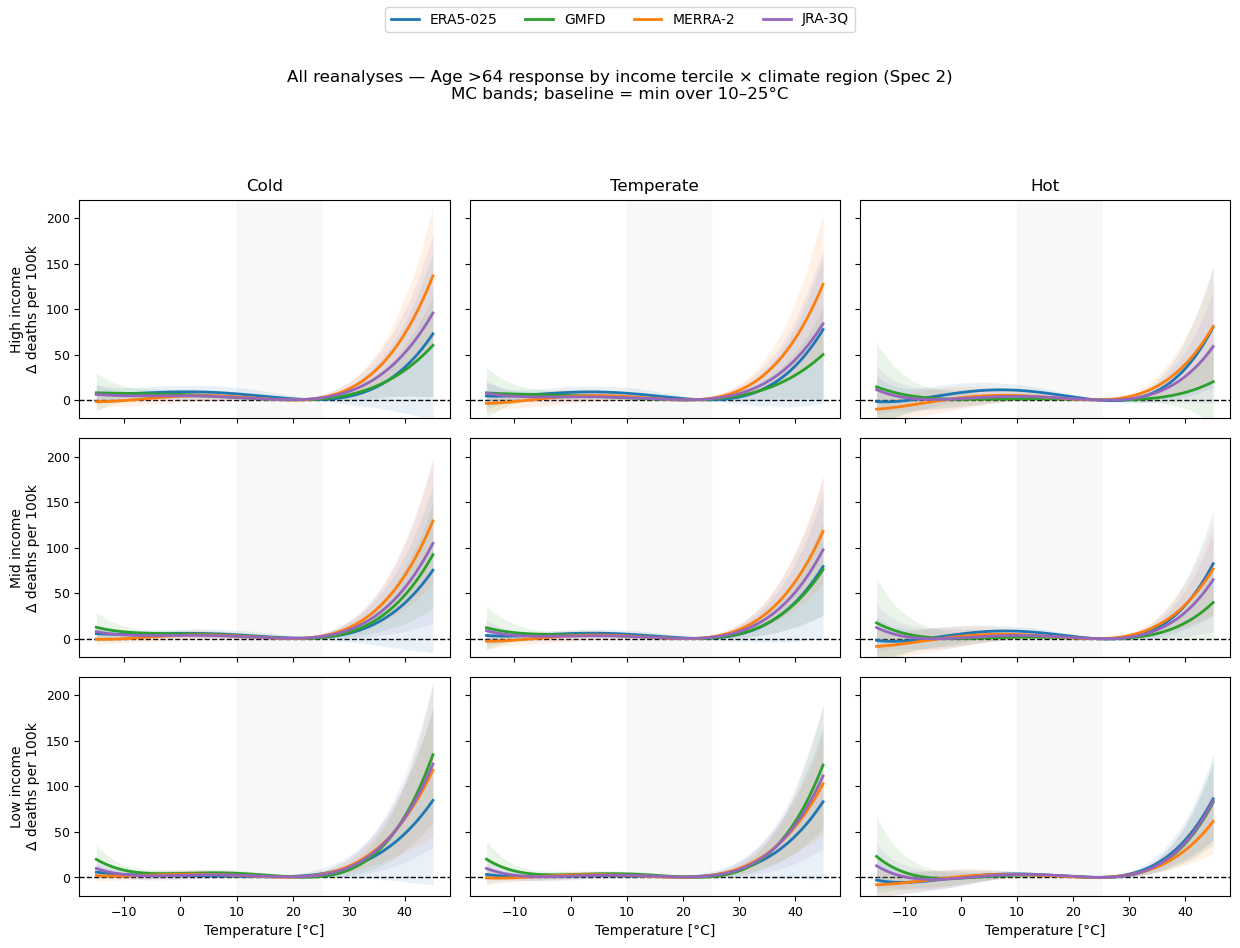


[Sanity] Population shares by tercile (%):
Income: {'high': 22.7, 'low': 55.9, 'mid': 21.5}
Temp  : {'cold': 26.2, 'hot': 49.6, 'temperate': 24.2}

[Sanity] Mean LR (°C) by cell:
temp_region  cold   hot  temperate
income_terc                       
high          8.1  15.1       10.6
low           9.2  20.0       11.4
mid           7.9  15.7       11.0

[Sanity] Mean log-income by cell:
temp_region   cold    hot  temperate
income_terc                         
high         10.52  10.32      10.47
low           9.36   9.36       9.40
mid          10.04  10.00      10.07


/tmp/8415216.1.debian.q/ipykernel_40995/3883765052.py:523: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [22]:
# fig1_overlay.py — Fully commented
# -----------------------------------------------------------------------------
# Purpose
# -------
# Recreate a 3×3 panel (income terciles × climate regions) of temperature
# response functions for Age 65+ with FOUR observational products overlaid.
#
# NEW (as requested):
#  • **Reference sourcing from GMFD-2010** — both *income (loggdppc)* and
#    *climate (LR: long-run mean temperature)* used to feed the response curves
#    are taken from the GMFD panel for 2010. The same GMFD-derived values are
#    then applied to every product’s curve. This makes the comparisons purely
#    about the *estimated γs* (and their uncertainty) rather than product-level
#    differences in covariates.
#
# Key design choices to ensure an apples-to-apples comparison ("isolate income"):
#  1) *Uniform cells across products*: we *fix* the bin assignment using
#     GMFD-2010 (gmfd_bins_labels.*). That means the same ADM2 sets define each
#     cell (income_terc × temp_region) for all products.
#  2) *Column-shared climate (optional)*: within each climate *column* (cold /
#     temperate / hot), for a given product we use the *same* long-run mean
#     temperature (LR) across the three income terciles when `USE_COLUMN_SHARED_LR=True`.
#     This removes cross-income LR differences within a column, so curves differ
#     within a column primarily through income effects and noise.
#  3) *Per-cell income*: for each product × cell, we compute a population-weighted
#     mean of log-income and (optionally) LR. If `USE_COLUMN_SHARED_LR=True`, we
#     ignore the per-cell LR and instead use the *region-level* LR to keep LR
#     constant within the column.
#  4) *MC uncertainty*: full coefficient draws using each product-specific
#     gamma and VCV from its CSVV. Curves are normalized to their minimum within
#     10–25°C so plots focus on *shape* differences, not additive levels.
#
# Takeaway: within a climate column, using column-shared LR means the only
# systematic difference across income terciles is the log-income entering the
# age×poly×{1,LR,logy} interaction terms. That isolates (as much as the model
# allows) the *income* shifter in the response.
# -----------------------------------------------------------------------------

from __future__ import annotations
import re
from pathlib import Path
from functools import lru_cache
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- Paths & constants -----------------------------
# Root repo and expected subpaths for bins, panels, and CSVVs.
BASE = Path("/user/ab5405/summeraliaclimate")
BINS_DIR   = BASE / "code/regressions/bins"                     # gmfd_bins_labels.*
PANELS_DIR = BASE / "code/regressions/prep_panels"              # global_mortality_panel_public_*.dta
CSVV_DIR   = BASE / "code/regressions/output/age_spec_interacted_csvv"  # agespec_interaction_response_spec2_*.csvv

# Four observational products to overlay
PRODUCTS = ["ERA5_025", "GMFD", "MERRA2", "JRA_3Q"]

# Reference year for bin construction and weights (matches GMFD bins vintage)
YEAR_REF = 2010

# We draw the 65+ block out of the age×poly×covariate tensor in the CSVV
AGE_LABEL = "65+"
AGE_IDX = 2   # age index in the gamma tensor: [0=0-4,1=5-64,2=65+] (your CSVV layout)

# Temperature plotting domain & normalization window
TMIN, TMAX = -15.0, 45.0
SLICE_MIN, SLICE_MAX = 10.0, 25.0   # baseline window to subtract min() over [10,25]

# Monte Carlo setup for uncertainty bands
N_DRAWS = 800
RNG = np.random.default_rng(123)

# Presentation style per product
PROD_STYLE = {
    "ERA5_025": dict(label="ERA5-025", color="#1f77b4"),
    "GMFD":     dict(label="GMFD",     color="#2ca02c"),
    "MERRA2":   dict(label="MERRA-2",  color="#ff7f0e"),
    "JRA_3Q":   dict(label="JRA-3Q",   color="#9467bd"),
}

# Panel layout ordering
INCS = ["high", "mid", "low"]
REGS = ["cold", "temperate", "hot"]

# Toggle: make LR constant within a climate *column* for a given product.
# If True, curves within the same climate region differ only due to income (logy)
# and stochastic variation; LR is column-shared.
USE_COLUMN_SHARED_LR = True

# ----------------------------- Utilities -----------------------------
def wavg(series: pd.Series, weights: pd.Series) -> float:
    """Safe population-weighted average with NaN/finite filters."""
    s = series.to_numpy(float)
    w = weights.to_numpy(float)
    m = np.isfinite(s) & np.isfinite(w) & (w > 0)
    return float(np.average(s[m], weights=w[m])) if m.any() else np.nan


def weighted_terciles_from_values(x: pd.Series, w: pd.Series) -> pd.Series:
    """Compute *global* (population-weighted) terciles; returns labels {low, mid, high}.
    Not used in the main flow because we import bins from gmfd_bins_labels.*,
    but included here for reference / reproducibility.
    """
    order = np.argsort(x.values)
    xs, ws = x.values[order], w.values[order]
    cdf = np.cumsum(ws) / ws.sum()
    t1 = xs[np.searchsorted(cdf, 1/3)]
    t2 = xs[np.searchsorted(cdf, 2/3)]
    return pd.cut(x, [-np.inf, t1, t2, np.inf], labels=["low","mid","high"], include_lowest=True)


def _lr_colname(cols, product: str) -> str:
    """Heuristics to find the LR column for a given product in a Stata panel."""
    for cand in (f"lr_tavg_{product}_adm1_avg", f"lr_tavg_{product.replace('_','-')}_adm1_avg"):
        if cand in cols:
            return cand
    # Final fallback: first LR column matching the pattern
    for c in cols:
        if re.fullmatch(r"lr_tavg_[^,]+_adm1_avg", c):
            return c
    raise KeyError(f"No lr_tavg_*_adm1_avg column found for {product}")


def _read_gamma_and_vcv(csvv_path: Path):
    """Parse gamma and its VCV from a CSVV-like text file.
    Expected blocks named 'gamma' and 'gammavcv'. We reshape to
    gamma[age=3, poly=4, cov=3], cov∈{intercept, LR, logy}.
    """
    txt = Path(csvv_path).read_text()
    _FLOAT = r"[-+]?(?:\d+\.?\d*|\.\d+)(?:[Ee][-+]?\d+)?"
    g_block = re.search(r"\bgamma\s*(.*?)\bgammavcv\b", txt, flags=re.S|re.I)
    v_block = re.search(r"\bgammavcv\b(.*)\Z",           txt, flags=re.S|re.I)
    if not g_block or not v_block:
        raise ValueError(f"Could not find gamma / gammavcv in {csvv_path}")
    g = [float(x) for x in re.findall(_FLOAT, g_block.group(1))]
    v = [float(x) for x in re.findall(_FLOAT, v_block.group(1))]
    gamma    = np.array(g[:36], float).reshape(3,4,3)     # [age, poly, cov(1,LR,logy)]
    gammavcv = np.array(v[:36*36], float).reshape(36,36)
    return gamma, gammavcv


def _mc_bands_for_cell(T, slice_min, slice_max, lr_tavg, loggdppc, gamma_mean, gamma_vcv,
                       age_index=AGE_IDX, n_draws=N_DRAWS, rng=RNG):
    """Compute MC mean and 90% bands for the response at given (LR, logy).

    Steps
    -----
    1) Draw gamma ~ N(gamma_mean, gamma_vcv) in vectorized form.
    2) Build effective polynomial coefficients b_k = b_k0 + b_k1*LR + b_k2*logy
       for k=1..4 (4th order), for the chosen age block.
    3) Evaluate polynomial across T and *normalize* by subtracting the minimum
       over [slice_min, slice_max]. This removes a level shift and focuses on
       relative risk across T.
    """
    g_flat = gamma_mean.reshape(-1)
    draws = rng.multivariate_normal(g_flat, gamma_vcv, size=n_draws).reshape(n_draws, 3, 4, 3)

    # Effective coefficients for this (LR, logy) at the requested age block
    b1 = draws[:, age_index, 0, 0] + draws[:, age_index, 0, 1]*lr_tavg + draws[:, age_index, 0, 2]*loggdppc
    b2 = draws[:, age_index, 1, 0] + draws[:, age_index, 1, 1]*lr_tavg + draws[:, age_index, 1, 2]*loggdppc
    b3 = draws[:, age_index, 2, 0] + draws[:, age_index, 2, 1]*lr_tavg + draws[:, age_index, 2, 2]*loggdppc
    b4 = draws[:, age_index, 3, 0] + draws[:, age_index, 3, 1]*lr_tavg + draws[:, age_index, 3, 2]*loggdppc
    eff = np.column_stack([b1, b2, b3, b4])

    # Evaluate the quartic across T
    Tpow = np.vstack([T, T**2, T**3, T**4])                 # shape (4, len(T))
    y_raw = eff @ Tpow                                      # shape (n_draws, len(T))

    # Normalize at min over [slice_min, slice_max]
    win = (T >= slice_min) & (T <= slice_max)
    base = np.nanmin(y_raw[:, win], axis=1)
    y = y_raw - base[:, None]

    y_mean = np.nanmean(y, axis=0)
    y_lo, y_hi = np.nanpercentile(y, [5, 95], axis=0)
    return y_mean, y_lo, y_hi

# ----------------------------- Bins (GMFD-2010) -----------------------------
# These functions import the *fixed* bin labels determined from GMFD-2010 and
# expose a mapping from (income_terc,temp_region) to sets of ADM2 IDs. That is
# what locks the cell membership uniformly across products.

def load_bins_labels(bins_dir: Path) -> pd.DataFrame:
    """Load gmfd_bins_labels.{csv|parquet} with columns:
        adm2_id, income_terc, temp_region
    The ADM2 assignments (cells) come from GMFD-2010 and are applied to *all*
    products to keep the geography per cell identical across products.
    """
    csv_path = bins_dir / "gmfd_bins_labels.csv"
    pq_path  = bins_dir / "gmfd_bins_labels.parquet"
    usecols  = ["adm2_id","income_terc","temp_region"]
    if csv_path.exists():
        out = pd.read_csv(csv_path, usecols=usecols, dtype={"adm2_id":"string"})
    elif pq_path.exists():
        out = pd.read_parquet(pq_path, columns=usecols)
    else:
        raise FileNotFoundError("gmfd_bins_labels.{csv|parquet} not found")
    out["adm2_id"] = out["adm2_id"].astype(str)
    out["income_terc"] = out["income_terc"].astype(str)
    out["temp_region"] = out["temp_region"].astype(str)
    return out


def build_cell_index(labels: pd.DataFrame) -> dict[tuple[str,str], set[str]]:
    """Return a dictionary mapping (income_terc,temp_region) → {ADM2 IDs}.
    This is the canonical cell definition we reuse for all products.
    """
    d = labels[["adm2_id","income_terc","temp_region"]].copy()
    d["cell"] = list(zip(d["income_terc"], d["temp_region"]))
    return {cell: set(g["adm2_id"]) for cell, g in d.groupby("cell")}

# ----------------------------- Cell means per product -----------------------------
# We now take the uniform cell definitions and compute *population-weighted* means
# of LR and log-income for each product × cell. Optionally, we compute a
# *column-shared* LR per climate region (union over income terciles) to hold LR
# fixed within each column when plotting.


def resolve_lr_col_from_file(dta_path: str | Path, product: str) -> str:
    """Probe a Stata file to find the correct LR column name for `product`."""
    chunk = next(iter(pd.read_stata(str(dta_path), iterator=True, chunksize=1000)))
    exact = f"lr_tavg_{product}_adm1_avg"
    if exact in chunk.columns:
        return exact
    cands = [c for c in chunk.columns if c.startswith("lr_tavg_") and c.endswith("_adm1_avg")]
    if len(cands) == 1:
        return cands[0]
    raise KeyError(f"LR col not found in {dta_path}. Tried '{exact}', candidates: {sorted(cands)}")


def cell_means_streaming(
    dta_path,
    product,
    ids_adm2,
    *,
    year=2010,
    weight_base="total",   # "total" or "age"
    age_label="65+",
    loginc_col="loggdppc_adm1_avg",
    lr_col=None,
    chunksize=200_000,
):
    """Return (lr_mean, loginc_mean) as *weighted averages across selected ADM2s*.

    Why streaming? Panels are large. We iterate in chunks, filter to the target
    year and ADM2 IDs, and collapse to one row per ADM2 to avoid double-counting
    ages.

    * `weight_base="total"` (default): sum population across all ages within ADM2
      in `year` (recommended for columns / bins that are not age-specific).
    * `weight_base="age"`: only the requested `age_label` population weights.

    LR/log-income are ADM2-level attributes in the panel; we take the first
    observed value per ADM2 within the chunk (equivalent to any, since constant).
    """
    import numpy as np, pandas as pd

    def _resolve_lr_col(path, product):
        exact = f"lr_tavg_{product}_adm1_avg"
        cols0 = next(iter(pd.read_stata(str(path), iterator=True, chunksize=1))).columns
        if exact in cols0:
            return exact
        cands = [c for c in cols0 if c.startswith("lr_tavg_") and c.endswith("_adm1_avg")]
        if len(cands)==1:
            return cands[0]
        raise KeyError(f"LR col not found. Tried {exact}; candidates={cands}")

    lr_col = lr_col or _resolve_lr_col(dta_path, product)

    need = ["adm2_id","year", "population", loginc_col, lr_col]
    if weight_base == "age":
        need += ["agegroup"]

    rdr = pd.read_stata(str(dta_path), iterator=True, chunksize=chunksize, columns=need)

    w_sum = 0.0
    wlr_sum = 0.0
    wlog_sum = 0.0

    ids_adm2 = set(map(str, ids_adm2))

    for ch in rdr:
        ch = ch.copy()
        ch["adm2_id"] = ch["adm2_id"].astype(str)

        # Filter to target year and ADM2 set
        ch = ch[(ch["year"] == year) & (ch["adm2_id"].isin(ids_adm2))]
        if ch.empty:
            continue

        # Choose weight base
        if weight_base == "age":
            ch = ch[ch["agegroup"] == age_label]
            if ch.empty:
                continue
            # Collapse within adm2_id: LR/logy constant within ADM2; sum weights
            sub = (ch.groupby("adm2_id", as_index=False)
                     .agg(pop=("population","sum"),
                          lr=(lr_col,"first"),
                          logy=(loginc_col,"first")))
        else:  # "total"
            # Collapse across all ages
            sub = (ch.groupby("adm2_id", as_index=False)
                     .agg(pop=("population","sum"),
                          lr=(lr_col,"first"),
                          logy=(loginc_col,"first")))

        sub = sub.dropna(subset=["pop","lr","logy"])
        if sub.empty:
            continue

        w = sub["pop"].to_numpy("float64")
        lr = sub["lr"].to_numpy("float64")
        lg = sub["logy"].to_numpy("float64")

        m = np.isfinite(w) & np.isfinite(lr) & np.isfinite(lg) & (w > 0)
        if not m.any():
            continue

        w = w[m]; lr = lr[m]; lg = lg[m]
        w_sum   += float(w.sum())
        wlr_sum += float((w * lr).sum())
        wlog_sum+= float((w * lg).sum())

    if w_sum == 0.0:
        raise ValueError("No rows matched after filtering/collapse.")

    return wlr_sum / w_sum, wlog_sum / w_sum


def build_CELL_MEANS_and_REGION_LR(products: list[str], dta_base: Path,
                                   idx: dict[tuple[str,str], set[str]]) -> tuple[dict, dict]:
    """For each product, compute per-cell means and optionally column-shared LR.

    Returns
    -------
    CELL_MEANS: dict[product → DataFrame(income_terc,temp_region,lr_mean,loginc)]
      Per-cell, population-weighted means. (loginc is per-cell and *always* used.)

    REGION_LR: dict[(product, temp_region) → lr_mean]
      When `USE_COLUMN_SHARED_LR=True`, this is used in place of per-cell LR.
      We compute it as the union of ADM2s across *all* income terciles for the
      region, so a single LR applies to the whole column.
    """
    dta_paths = {p: dta_base / f"global_mortality_panel_public_{p}.dta" for p in products}
    CELL_MEANS = {}
    REGION_LR  = {}
    for prod in products:
        rows = []
        # Column-shared LR per region (union over income terciles)
        for reg in REGS:
            ids_union = set().union(*(idx.get((inc, reg), set()) for inc in INCS))
            if ids_union:
                lr_mean_reg, _ = cell_means_streaming(dta_paths[prod], prod, ids_union)
                REGION_LR[(prod, reg)] = float(lr_mean_reg)
        # Per-cell means (we *always* use per-cell income)
        for inc in INCS:
            for reg in REGS:
                ids = idx.get((inc, reg), set())
                if not ids:
                    continue
                lr_mean, log_mean = cell_means_streaming(dta_paths[prod], prod, ids)
                rows.append([inc, reg, float(lr_mean), float(log_mean)])
        CELL_MEANS[prod] = pd.DataFrame(rows, columns=["income_terc","temp_region","lr_mean","loginc"])
    return CELL_MEANS, REGION_LR

# ----------------------------- Reference inputs from GMFD (2010) -----------------------------
# These functions build the *single source of truth* for LR and log-income
# used in plotting *for all products*.

def build_reference_from_GMFD(dta_base: Path,
                              idx: dict[tuple[str,str], set[str]],
                              *,
                              year: int = YEAR_REF) -> tuple[pd.DataFrame, dict[str, float]]:
    """Compute GMFD-based reference values:

    Returns
    -------
    ref_cell_means : DataFrame with columns [income_terc, temp_region, lr_mean, loginc]
        Population-weighted per-cell LR and log-income computed from the GMFD panel in `year`.
    ref_region_lr : dict[temp_region → lr_mean]
        Column-shared LR per climate region, pooling over the income terciles (GMFD-only).
    """
    gmfd_path = dta_base / "global_mortality_panel_public_GMFD.dta"

    # Per-region LR (column-shared): union of ADM2s across income terciles
    ref_region_lr: dict[str, float] = {}
    for reg in REGS:
        ids_union = set().union(*(idx.get((inc, reg), set()) for inc in INCS))
        if not ids_union:
            continue
        lr_mean_reg, _ = cell_means_streaming(gmfd_path, "GMFD", ids_union, year=year)
        ref_region_lr[reg] = float(lr_mean_reg)

    # Per-cell LR and log-income (GMFD-only)
    rows = []
    for inc in INCS:
        for reg in REGS:
            ids = idx.get((inc, reg), set())
            if not ids:
                continue
            lr_mean, log_mean = cell_means_streaming(gmfd_path, "GMFD", ids, year=year)
            rows.append([inc, reg, float(lr_mean), float(log_mean)])

    ref_cell_means = pd.DataFrame(rows, columns=["income_terc","temp_region","lr_mean","loginc"])
    return ref_cell_means, ref_region_lr

# ----------------------------- Plot (Figure 1 overlay) -----------------------------

def plot_overlay_3x3(ref_cell_means: pd.DataFrame,
                     ref_region_lr: dict[str,float],
                     gamma_cache: dict[str, tuple[np.ndarray,np.ndarray]],
                     *,
                     use_column_shared_lr: bool = True):
    """Plot the 3×3 grid and overlay product curves with 90% MC bands.

    If `use_column_shared_lr` is True, we replace the cell-specific LR with the
    region LR so that, within a climate column, all three income terciles share
    the *same* LR. This is the principal mechanism to isolate income variation.
    """
    T = np.linspace(TMIN, TMAX, 800)
    fig, axes = plt.subplots(3, 3, figsize=(12.5, 9.5), sharex=True, sharey=True)
    legend_handles = []
    for i, inc in enumerate(INCS):
        for j, reg in enumerate(REGS):
            ax = axes[i, j]
            # Visual baseline window and zero line
            ax.axvspan(SLICE_MIN, SLICE_MAX, color="0.9", alpha=0.25, zorder=0)
            ax.axhline(0, color="k", ls="--", lw=1, zorder=1)

            # Pull GMFD-referenced per-cell values (same for all products)
            r = ref_cell_means[(ref_cell_means.income_terc==inc) & (ref_cell_means.temp_region==reg)]
            if r.empty:
                continue
            row = r.iloc[0]

            # LR for plotting: either column-shared (GMFD-only) or per-cell (GMFD-only)
            lr_for_panel = ref_region_lr[reg] if use_column_shared_lr else float(row.lr_mean)
            # Per-cell income is always from GMFD reference now
            loginc_for_panel = float(row.loginc)

            for prod in PRODUCTS:
                gm, gv = gamma_cache[prod]
                y_mean, y_lo, y_hi = _mc_bands_for_cell(
                    T, SLICE_MIN, SLICE_MAX,
                    lr_tavg=lr_for_panel,
                    loggdppc=loginc_for_panel,
                    gamma_mean=gm, gamma_vcv=gv,
                    age_index=AGE_IDX, n_draws=N_DRAWS, rng=RNG
                )
                style = PROD_STYLE[prod]
                (ln,) = ax.plot(T, y_mean, lw=2.0, **style, zorder=3)
                ax.fill_between(T, y_lo, y_hi, alpha=0.10, color=style["color"], linewidth=0, zorder=2)
                if i==0 and j==0:
                    legend_handles.append(ln)

            if i == 0: ax.set_title(reg.capitalize())
            if j == 0: ax.set_ylabel(f"{inc.capitalize()} income\nΔ deaths per 100k")

    for ax in axes[-1, :]:
        ax.set_xlabel("Temperature [°C]")
    for ax in axes.flat:
        ax.set_ylim(-20, 220)
        ax.set_yticks([0,50,100,150,200])
        ax.tick_params(labelsize=9)

    fig.subplots_adjust(top=0.84)
    fig.legend(handles=legend_handles,
               labels=[PROD_STYLE[p]["label"] for p in PRODUCTS],
               loc="upper center", ncol=len(PRODUCTS), frameon=True, fontsize=10)
    fig.suptitle(
        "All reanalyses — Age >64 response by income tercile × climate region (Spec 2)\n"
        "MC bands; baseline = min over 10–25°C",
        y=0.93
    )
    plt.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()

# ----------------------------- Sanity checks -----------------------------
# These help confirm that
#  (i) the bins align with 2010 population shares and
#  (ii) the weighted means behave monotonically across income/temperature cells.


def sanity_population_shares(bins: pd.DataFrame, panel2010: pd.DataFrame):
    """Print population shares by income tercile and temp region for 2010.
    Uses GMFD panel only to mirror bin construction.
    """
    use = ["adm2_id","year","agegroup","population","lr_tavg_GMFD_adm1_avg","loggdppc_adm1_avg"]
    df2010 = panel2010[use].copy()
    df2010 = df2010[df2010["year"]==YEAR_REF].copy()
    df2010["adm2_id"] = df2010["adm2_id"].astype(str)

    # Collapse to ADM2 totals (all ages), keep ADM2-level LR/log-income
    adm2_agg = (df2010
        .sort_values(["adm2_id","agegroup"])
        .groupby("adm2_id", as_index=False)
        .agg(pop2010=("population","sum"),
             lr=("lr_tavg_GMFD_adm1_avg","first"),
             logy=("loggdppc_adm1_avg","first"))
        .dropna(subset=["pop2010","lr","logy"]))

    merged = bins.merge(adm2_agg, on="adm2_id", how="left")

    inc_share = (merged.groupby("income_terc")["pop2010"].sum() / merged["pop2010"].sum() * 100).round(1)
    tmp_share = (merged.groupby("temp_region")["pop2010"].sum() / merged["pop2010"].sum() * 100).round(1)
    print("\n[Sanity] Population shares by tercile (%):")
    print("Income:", inc_share.to_dict())
    print("Temp  :", tmp_share.to_dict())


def sanity_monotonic_means(bins: pd.DataFrame, panel2010: pd.DataFrame):
    """Check that LR rises across temp regions and log-income rises across income.
    This is tolerant and intended as a quick tripwire for obvious mis-binnings.
    """
    use = ["adm2_id","year","agegroup","population","lr_tavg_GMFD_adm1_avg","loggdppc_adm1_avg"]
    df2010 = panel2010[use].copy()
    df2010 = df2010[df2010["year"]==YEAR_REF].copy()
    df2010["adm2_id"] = df2010["adm2_id"].astype(str)

    # attach bins
    merged = df2010.merge(bins, on="adm2_id", how="left")
    tab = (merged.groupby(["income_terc","temp_region"])
           .apply(lambda g: pd.Series({
               "lr_mean"  : wavg(g["lr_tavg_GMFD_adm1_avg"], g["population"]),
               "logy_mean": wavg(g["loggdppc_adm1_avg"],     g["population"])
           }))
           .reset_index())

    print("\n[Sanity] Mean LR (°C) by cell:")
    print(tab.pivot(index="income_terc", columns="temp_region", values="lr_mean").round(1))
    print("\n[Sanity] Mean log-income by cell:")
    print(tab.pivot(index="income_terc", columns="temp_region", values="logy_mean").round(2))

    # Monotone checks (tolerant).
    for inc in INCS:
        row = tab[tab["income_terc"]==inc].set_index("temp_region").loc[REGS, "lr_mean"].to_numpy()
        assert np.all(np.diff(row) >= -1e-6), f"Non-monotone LR across regions for income={inc}"

    for reg in REGS:
        col = tab[tab["temp_region"]==reg].set_index("income_terc").loc[["low","mid","high"], "logy_mean"].to_numpy()
        assert np.all(np.diff(col) >= -1e-6), f"Non-monotone log-income across income terciles for region={reg}"

# ----------------------------- Main -----------------------------

def main():
    # 1) Load GMFD bins (2010) — lock uniform cell membership
    bins = load_bins_labels(BINS_DIR)
    idx = build_cell_index(bins)

    # 2) Build GMFD-based reference inputs (per-cell log-income & LR; per-region LR)
    REF_CELL_MEANS, REF_REGION_LR = build_reference_from_GMFD(PANELS_DIR, idx, year=YEAR_REF)

    # 3) Load CSVVs (gamma + VCV) per product
    gamma_cache = {}
    for prod in PRODUCTS:
        csvv_path = CSVV_DIR / f"agespec_interaction_response_spec2_{prod}.csvv"
        gm, gv = _read_gamma_and_vcv(csvv_path)
        gamma_cache[prod] = (gm, gv)

    # 4) Plot overlay (Figure 1) using GMFD-referenced covariates for ALL products
    plot_overlay_3x3(REF_CELL_MEANS, REF_REGION_LR, gamma_cache,
                     use_column_shared_lr=USE_COLUMN_SHARED_LR)

    # 5) Sanity checks using GMFD panel (mirrors bin vintage)
    gmfd_panel_path = PANELS_DIR / "global_mortality_panel_public_GMFD.dta"
    gmfd2010 = pd.read_stata(str(gmfd_panel_path), iterator=False, convert_categoricals=False)
    sanity_population_shares(bins, gmfd2010)
    sanity_monotonic_means(bins, gmfd2010)

if __name__ == "__main__":
    main()
